Course name: Natural Language Processing & Text Mining  
Course code: 472867-HS2024-0  
Project Task 3: BERT and GPT-Like Models

Autumn Semester 2024-2025  
Master in Artificial Intelligence for Medicine  
Universität Bern  

*Group Members: Rachel Robles (23-125-966), Corina Hüni (19-819-903), Chanae Smith (23-107-915)*    

-----------------------------


In [1]:
# Imports 
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline 
import torch 
import csv
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast


In [2]:
# Load the dataset
dataset = load_dataset("argilla/medical-domain")
train_data = dataset['train']

# **PART A - Implementation of bert-base-uncased_clinical-ner**  
---

_Apply BERT-like models from https://huggingface.co/models?sort=trending&search=bert for the main task on your project data._

- We have chosen the samrawal/bert-base-uncased_clinical-ner model for performing NER on our clinical report dataset due to its domain-specific training and robust architecture. 
- This model has been fine-tuned on clinical and biomedical data, enabling it to accurately recognize entities such as medical conditions, treatments, symptoms, medications, and anatomical terms. 
- Given the NER types identified in our dataset during Task 2 of the project (like diagnosis, symptoms, medications, etc) this model is tailored to handle these entities far better than general-purpose NER models.
- It is built on the BERT architecture, so the model benefits from contextual embeddings - this is particularly useful in clinical text where terminology can be ambiguous or context-sensitive. 
- The uncased nature of this model also suits clinical data well, as medical terms are often written in lowercase, reducing the risk of errors caused by inconsistent capitalization.

In [3]:
# Load the model and tokenizer
model_name = "samrawal/bert-base-uncased_clinical-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Determine the device
device_index = 0 if torch.cuda.is_available() else -1

# Print if using GPU or CPU
if device_index == 0:
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
# Create the NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, device = device_index) # runs the specific model in NER mode

In [6]:
# Process data and extract entities
entities = ner_pipeline(train_data['text'])

In [7]:
for entity in entities[10:12]:
    for ent in entity:
        print(f"Entity: {ent['word']}, Label: {ent['entity']}, Score: {ent['score']:.4f}")

Entity: vi, Label: B-problem, Score: 0.9983
Entity: ##tre, Label: I-problem, Score: 0.9864
Entity: ##ous, Label: I-problem, Score: 0.5843
Entity: hem, Label: I-problem, Score: 0.9974
Entity: ##or, Label: I-problem, Score: 0.9972
Entity: ##rh, Label: I-problem, Score: 0.9973
Entity: ##age, Label: I-problem, Score: 0.9979
Entity: re, Label: B-problem, Score: 0.9946
Entity: ##tina, Label: B-problem, Score: 0.5280
Entity: ##l, Label: I-problem, Score: 0.9614
Entity: detachment, Label: I-problem, Score: 0.9966
Entity: vi, Label: B-problem, Score: 0.9978
Entity: ##tre, Label: I-problem, Score: 0.9580
Entity: ##ous, Label: I-problem, Score: 0.9577
Entity: hem, Label: I-problem, Score: 0.9967
Entity: ##or, Label: I-problem, Score: 0.9975
Entity: ##rh, Label: I-problem, Score: 0.9975
Entity: ##age, Label: I-problem, Score: 0.9973
Entity: re, Label: B-problem, Score: 0.9939
Entity: ##tina, Label: B-problem, Score: 0.7215
Entity: ##l, Label: I-problem, Score: 0.9555
Entity: detachment, Label: I-p

#### *Findings*

- The model is designed for token classification and follows the BIO (Beginning-Inside-Outside) tagging scheme. 
- The labels are as follows:
    1. Problem: Used for medical conditions, symptoms, and diagnoses.
    2. Treatment: Covers treatments, medications, or procedures.
    3. Test: Refers to diagnostic tests or lab tests.
    4. O: Marks tokens that do not belong to any of the defined entities.
- Tokens beginning with **"##"** indicate they are continuations of the previous token.
    - The separation of entities like **"hemorrhage"** into tokens such as **"hem"**, **"##or"**, **"##rh"**, and **"##age"** is due to WordPiece tokenization, which BERT-based models use to handle rare or complex words. 
    - This essentially breaks words into smaller, recognizable subword units to reduce vocabulary size while covering a wide range of terms. 
    - This approach allows the model to process uncommon medical terminology effectively by assigning NER labels to each subword, ensuring the entire term is correctly classified. 


In [8]:
# Flatten the entities to make them a list of dictionaries
flattened_entities = []
for entity in entities:
    for ent in entity:
        flattened_entities.append({
            "word": ent["word"],
            "entity": ent["entity"],
            "score": ent["score"]
        })

# Save to CSV
with open('entities.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=["word", "entity", "score"])
    writer.writeheader()
    writer.writerows(flattened_entities)

# **PART B - Evaluation with Custom Annotations**  
---

In [9]:
# Load the model and labels
model = ner_pipeline.model
labels = model.config.id2label
print("Model Labels:", labels)

Model Labels: {0: 'B-problem', 1: 'B-treatment', 2: 'I-test', 3: 'I-treatment', 4: 'B-test', 5: 'O', 6: 'I-problem'}


In [10]:
def map_annotations_to_model(annotation_label):
    mapping = {
        "MEDICAL DIAGNOSIS": "B-problem",
        "SYMPTOM": "B-problem",
        "MEDICAL PROCEDURE": "B-treatment",
        "MEDICATION": "B-treatment",
        # Our other custom labels like 'Anatomical Locations' cannot be directly mapped
    }
    return mapping.get(annotation_label, None)  # Return None for unmapped labels

In [11]:
# Load the CSV annotations file
input_file = "annotations_gt.csv"
df = pd.read_csv(input_file)

# Parse the annotations from the 'entities' column
annotations = []
for _, row in df.iterrows():
    text = row['text']  # Extract the text
    entities_str = row['entities']  # Extract the entities as a string
    entities = ast.literal_eval(entities_str)  # Convert string back to list of tuples
    annotations.append({'text': text, 'entities': entities})

# Display an example of annotations for the first sample
print(annotations[0]['entities'])


[('Iron deficiency anemia', 'MEDICAL DIAGNOSIS'), ('Diverticulosis', 'MEDICAL DIAGNOSIS'), ('Colonoscopy', 'MEDICAL PROCEDURE'), ('MAC.', 'MEDICATION'), ('rectum', 'ANATOMICAL LOCATION'), ('colon', 'ANATOMICAL LOCATION'), ('cecum', 'ANATOMICAL LOCATION'), ('ileocecal valve', 'ANATOMICAL LOCATION'), ('appendiceal orifice', 'ANATOMICAL LOCATION'), ('cecum', 'ANATOMICAL LOCATION'), ('mucosa', 'ANATOMICAL LOCATION'), ('colon', 'ANATOMICAL LOCATION'), ('polyps', 'MEDICAL DIAGNOSIS'), ('lesions', 'MEDICAL DIAGNOSIS'), ('diverticula', 'MEDICAL DIAGNOSIS'), ('sigmoid colon', 'ANATOMICAL LOCATION'), ('luminal narrowing', 'MEDICAL DIAGNOSIS'), ('inflammation', 'MEDICAL DIAGNOSIS'), ('anorectal junction', 'ANATOMICAL LOCATION'), ('hemorrhoids.', 'MEDICAL DIAGNOSIS'), ('1', 'CARDINAL'), ('Diverticulosis', 'MEDICAL DIAGNOSIS'), ('sigmoid', 'ANATOMICAL LOCATION'), ('2', 'CARDINAL'), ('colonoscopy', 'MEDICAL PROCEDURE'), ('cecum', 'ANATOMICAL LOCATION'), ('1', 'CARDINAL'), ('Dr. X', 'PERSON'), ('2', 

In [12]:
# Read the CSV file
with open('entities.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    entities = []
    for row in reader:
        entities.append({
            "word": row["word"],
            "entity": row["entity"],
            "score": float(row["score"])  # Convert score back to float if needed
        })


In [13]:
# Count the occurrences of each label
label_counts = Counter(entity["entity"] for entity in entities)

In [14]:
# Print the results
print("Label counts:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Label counts:
B-problem: 99268
I-problem: 254658
B-treatment: 64991
I-treatment: 185915
B-test: 30807
I-test: 60611


In [15]:
# Display the first 10 entities
print("\nSample entities:")
for entity in entities[:10]:
    print(entity)


Sample entities:
{'word': 'iron', 'entity': 'B-problem', 'score': 0.9986727}
{'word': 'deficiency', 'entity': 'I-problem', 'score': 0.9988495}
{'word': 'an', 'entity': 'I-problem', 'score': 0.9988937}
{'word': '##emia', 'entity': 'I-problem', 'score': 0.999084}
{'word': 'divert', 'entity': 'B-problem', 'score': 0.99799937}
{'word': '##ic', 'entity': 'I-problem', 'score': 0.99665725}
{'word': '##ulo', 'entity': 'I-problem', 'score': 0.9414933}
{'word': '##sis', 'entity': 'I-problem', 'score': 0.98919266}
{'word': 'colon', 'entity': 'B-treatment', 'score': 0.7855559}
{'word': '##os', 'entity': 'I-treatment', 'score': 0.41980147}


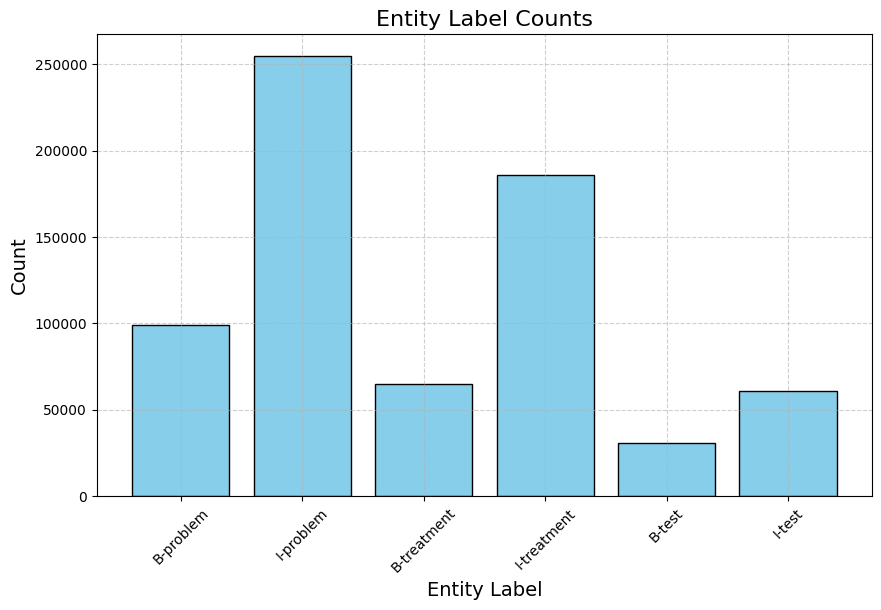

In [16]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
labels = list(label_counts.keys())
counts = list(label_counts.values())
plt.bar(labels, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.title("Entity Label Counts", fontsize=16)
plt.xlabel("Entity Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

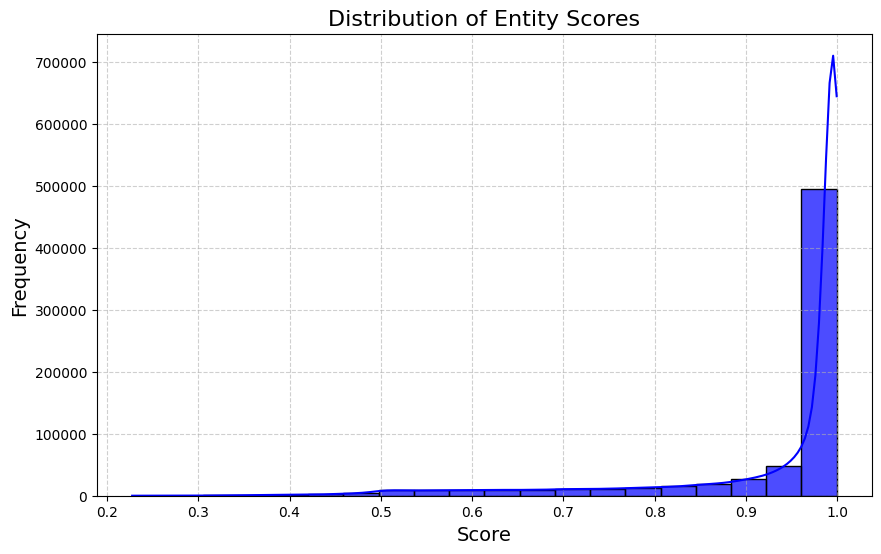

In [ ]:
# Create a df for score-based visualizations
df = pd.DataFrame(entities)

# Plot the histogram for entity scores
plt.figure(figsize=(10, 6))
sns.histplot(df["score"], bins=20, kde=True, color='blue', alpha=0.7)
plt.title("Distribution of Entity Scores", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


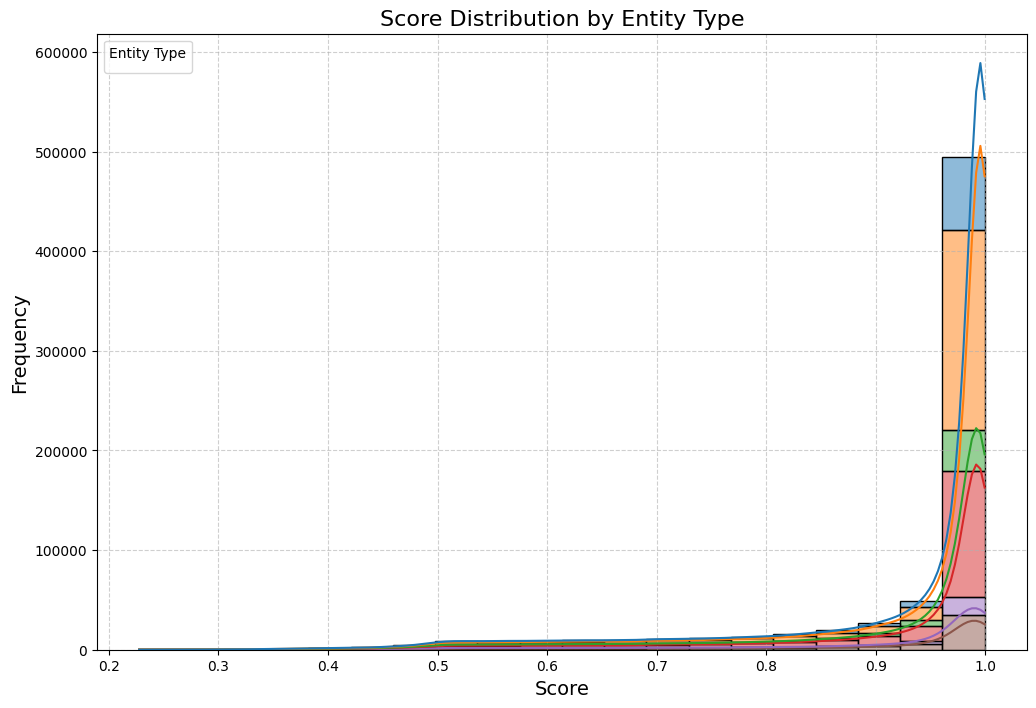

In [22]:
# Plot the histogram for each entity type
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x="score", hue="entity", bins=20, kde=True, palette="tab10", multiple="stack")
plt.title("Score Distribution by Entity Type", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(title="Entity Type")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

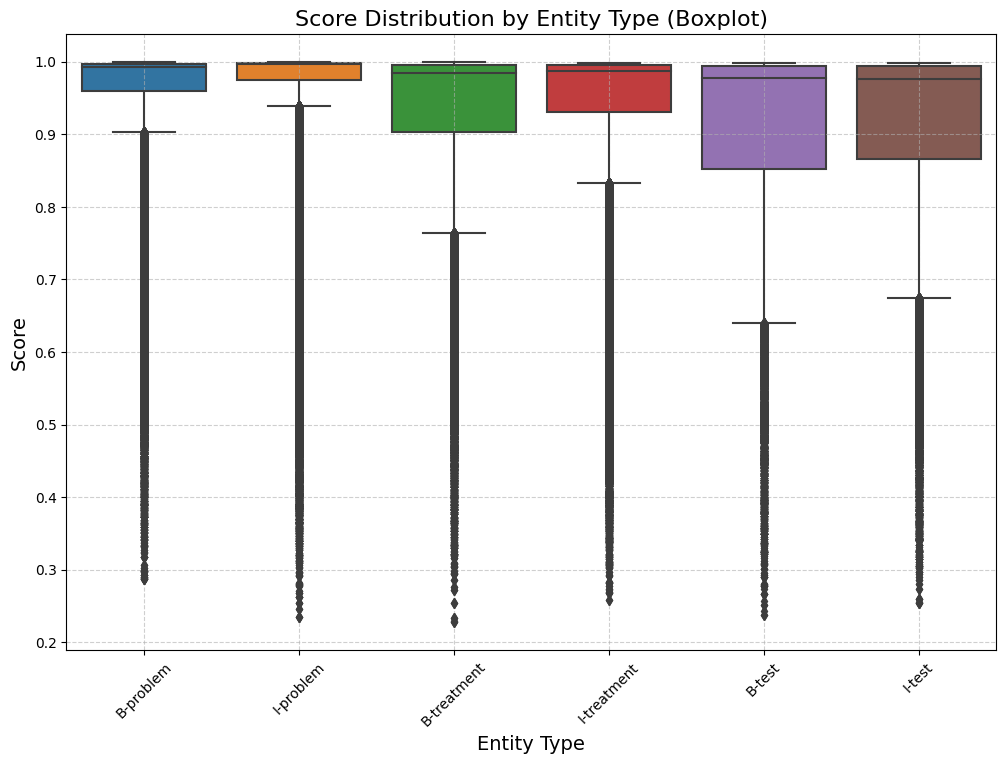

In [23]:
# Boxplot for score distribution by entity type
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x="entity", y="score", palette="tab10")
plt.title("Score Distribution by Entity Type (Boxplot)", fontsize=16)
plt.xlabel("Entity Type", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [24]:
# Filter entities with low scores
low_score_entities = [entity for entity in entities if entity['score'] < 0.5]
print(f"\nNumber of entities with score < 0.5: {len(low_score_entities)}")
print(f"Total number of entities: {len(entities)}")


Number of entities with score < 0.5: 10871
Total number of entities: 696250


#### *Findings*

1. **Entity Label Counts** bar chart: 
    - The most frequently identified entities are **I-problem** and **I-treatment**, likely because the reports in our dataset contain multi-word medical problems and treatments. 
    - **B-test** and **I-test** are relatively underrepresented, maybe because test-related entities might appear less frequently in the dataset or are harder to identify consistently. 

2. **Distribution of Entity Scores** histograms:
    - The majority of entities are identified with scores near **1.0**, reflecting high confidence in the predictions. 
    - There are a few low-confidence predictions (scores below **0.5**), particularly for entities like **I-treatment** and **I-test**. 

3. **Score Distribution by Entity Type** graphs:
    - Problems and treatments have relatively consistent and high-confidence predictions compared to tests, which exhibit a wider spread in scores.

# **PART C - Discussion on Applying BERT-Like Models**  
---

One of the main challenges we encountered when selecting a BERT-like model for this task was the limited availability of models that were both pre-trained on medical data and equipped with a suitable classification head. For instance, while the **Bio_ClinicalBERT** model seemed like a strong candidate due to its domain-specific training, we faced the issue of uninitialized weights in the classification layer. This error indicated that the model lacked a pre-trained classification head, meaning the weights for the NER task had not been set during pre-training. As a result, attempting to use the model out-of-the-box for NER tasks led to random initialization of these weights, reducing the reliability and effectiveness of the predictions.

This limitation implied that fine-tuning the Bio_ClinicalBERT model on our dataset was necessary to achieve optimal performance. However, fine-tuning a BERT model requires substantial time, computational resources, and a sufficiently large annotated dataset to avoid overfitting. Given the scope, our dataset of only 100 annotated samples, and the constraints of our project, fine-tuning was not feasible. Our focus was on applying pre-trained models directly rather than training them further.

Ultimately, we opted for the **bert-base-uncased_clinical-ner** model because it came with a pre-trained classification head specifically designed for clinical NER tasks. This allowed us to bypass the need for fine-tuning while still achieving NER results. We found that the lack of advanced, ready-to-use, domain-specific models with pre-trained classification heads highlights a gap in the current offerings of BERT-like models for medical NER. 